In [ ]:
pip install duckdb boto3 rasterio shapely mercantile matplotlib geopandas

     ---------------------------------------- 0.0/899.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/899.2 kB ? eta -:--:--
     --------------------------------- ---- 786.4/899.2 kB 3.8 MB/s eta 0:00:01
     ---------------------------------------- 899.2/899.2 kB 3.5 MB/s  0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build gdal
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for gdal (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [148 lines of output]
      Using numpy 2.4.2
      C:\Users\DJ\AppData\Local\Temp\pip-build-env-e_q8z8fw\overlay\Lib\site-packages\setuptools\config\_apply_pyprojecttoml.py:82: SetuptoolsWarning: `license` overwritten by `pyproject.toml`
        corresp(dist, value, root_dir)
      C:\Users\DJ\AppData\Local\Temp\pip-build-env-e_q8z8fw\overlay\Lib\site-packages\setuptools\config\_apply_pyprojecttoml.py:82: SetuptoolsWarning: `extras_require` overwritten in `pyproject.toml` (optional-dependencies)
        corresp(dist, value, root_dir)
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-314\osgeo
      copying osgeo\gdal.py -> build\lib.win-amd64-cpython-314\osgeo
      copying osgeo\gdalconst.py -> build\lib.win-amd64-cpython-314\osgeo
      copying osgeo\gdalnumeric.py -> build\lib.win-amd64-c

In [1]:
import rasterio
import duckdb
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from rasterio.windows import from_bounds
from rasterio.io import MemoryFile
from rasterio.mask import mask
from rasterio.session import AWSSession
from shapely.geometry import box, mapping
from rasterio.plot import show
import os
import mercantile as merc
from matplotlib import pyplot

In [20]:
#importing buildings from Microsoft building footprints dataset
duckdb.sql('INSTALL httpfs')
duckdb.sql('LOAD httpfs')
duckdb.sql('INSTALL spatial')
duckdb.sql('LOAD spatial')

#s3 bucket with the dataset
prefix = "https://data.source.coop/hdx/microsoft-open-buildings/RegionName=UnitedStates/quadkey=023111311/part-00084-66ec874b-f074-4991-9da4-67716003c6cd.c000.parquet"

totalcount = duckdb.sql(f"SELECT COUNT(*) FROM read_parquet('{prefix}')")

totalcount

#columns = duckdb.sql(f"DESCRIBE SELECT * FROM read_parquet('{prefix}')")
#columns

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│       731755 │
└──────────────┘

In [23]:
#minx, miny = -90.394478,38.555146 lowerleft
#  -90.181618,38.555146   #lowerright
#   -90.181618,38.686850 #upperright
# -90.394478,38.686850 #upperleft
#maxx, maxy = -90.181618,38.686850

# Connect to DuckDB (in-memory)
con = duckdb.connect()

# Optional: Install and load spatial extension for advanced geo-clipping
con.execute("INSTALL spatial; LOAD spatial;") 
con.execute("INSTALL httpfs; LOAD httpfs;")


minx, miny = -90.394478,38.555146
maxx, maxy = -90.181618,38.686850

prefix = "https://data.source.coop/hdx/microsoft-open-buildings/RegionName=UnitedStates/quadkey=023111311/part-00084-66ec874b-f074-4991-9da4-67716003c6cd.c000.parquet"

query = f""" SELECT * FROM read_parquet('{prefix}') WHERE ST_INTERSECTS(geometry, ST_MakeEnvelope({minx},{miny},{maxx},{maxy}))"""


clip_result = con.sql(query)
clip_result.show()

con.execute(f"COPY ({query}) TO 'Stl_buildings.parquet' (FORMAT PARQUET)")

#duck_box = duckdb.sql(f"SELECT * FROM read_parquet('{prefix}') WHERE ST_INTERSECTS(geometry, ST_SetSRID(ST_GeomFromText('POLYGON((-90.394478 38.555146, -90.181618 38.555146, -90.181618 38.686850, -90.394478 38.686850, -90.394478 38.555146))'), 26915))");

┌────────────────────┬────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────────────────────────────────────────────────────────────────────────────┬──────────────┬───────────┐
│       height       │ confidence │                                                                                                                                        geometry                                                                                                                                         │                                 geometry_bbox                                  │  RegionName  │  quadkey  │
│       double       │   double   │                                                                                                                 

In [3]:
# testing Rasterio without manual boto3

bucket = 'prd-tnm'
key='StagedProducts/Elevation/13/TIFF/historical/n39w091/USGS_13_n39w091_20240228.tif' #STL Area

session = AWSSession(
    boto3.Session(),
    requester_pays=False,
    aws_unsigned=True
)

with rasterio.Env(session):
    with rasterio.open(f"s3://{bucket}/{key}") as src:
        print(src.bounds)

# Define clip area
minx, miny = -90.394478,38.555146
maxx, maxy = -90.181618,38.686850

geom = [mapping(box(minx, miny, maxx, maxy))]


#Clip raster to localized area (TESTING small first) and save locally

with MemoryFile(data) as memfile:
    with memfile.open() as src:
        out_image, out_transform = mask(src, geom, crop=True)
        out_meta = src.meta.copy()

out_meta.update({
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

output_path = "clipped_dem_stl.tif"

with rasterio.open(output_path, "w", **out_meta) as dest:
    dest.write(out_image)

BoundingBox(left=-91.00055555589358, bottom=37.99944444350717, right=-89.9994444437055, top=39.00055555659458)


NameError: name 'data' is not defined

In [4]:
# Streaming GeoTIFF from USGS S3 Bucket
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

bucket = 'prd-tnm'
key='StagedProducts/Elevation/13/TIFF/historical/n39w091/USGS_13_n39w091_20240228.tif' #STL Area

response = s3.get_object(Bucket=bucket, Key=key)
data = response["Body"].read()

#Open in Rasterio in Memory
with MemoryFile(data) as memfile:
    with memfile.open() as dataset:

        print(dataset.crs)
        print(dataset.bounds)

# Define clip area
minx, miny = -90.394478,38.555146
maxx, maxy = -90.181618,38.686850

geom = [mapping(box(minx, miny, maxx, maxy))]
stl_bbox = merc.LngLatBbox(minx, miny, maxx, maxy)

#Clip raster to localized area (TESTING small first) and save locally

with MemoryFile(data) as memfile:
    with memfile.open() as src:
        out_image, out_transform = mask(src, geom, crop=True)
        out_meta = src.meta.copy()

out_meta.update({
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

output_path = "clipped_dem_stl.tif"



with rasterio.open(output_path, "w", **out_meta) as dest:
    dest.write(out_image)

GEOGCS["NAD83",DATUM["North American Datum 1983",SPHEROID["GRS 1980",6378137,298.257222101004]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
BoundingBox(left=-91.00055555589358, bottom=37.99944444350717, right=-89.9994444437055, top=39.00055555659458)


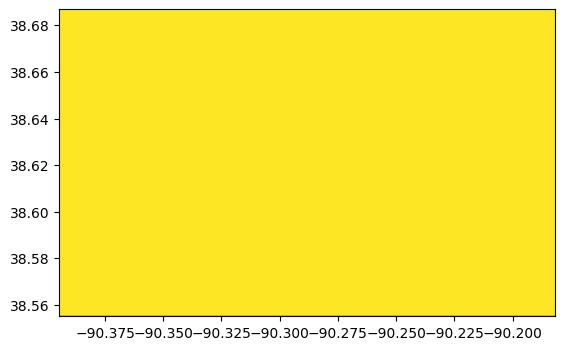

<Axes: >

In [ ]:
src_crs = 'EPSG:4326'
dst_crs = 'EPSG:26915'

dem_reprojected = rasterio.warp._calculate_default_transform

NameError: name 'merc' is not defined